## Part 1: Analyze the Fake News Dataset

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mariu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


unique words in raw text: 20948
unique words in cleaned text: 16608


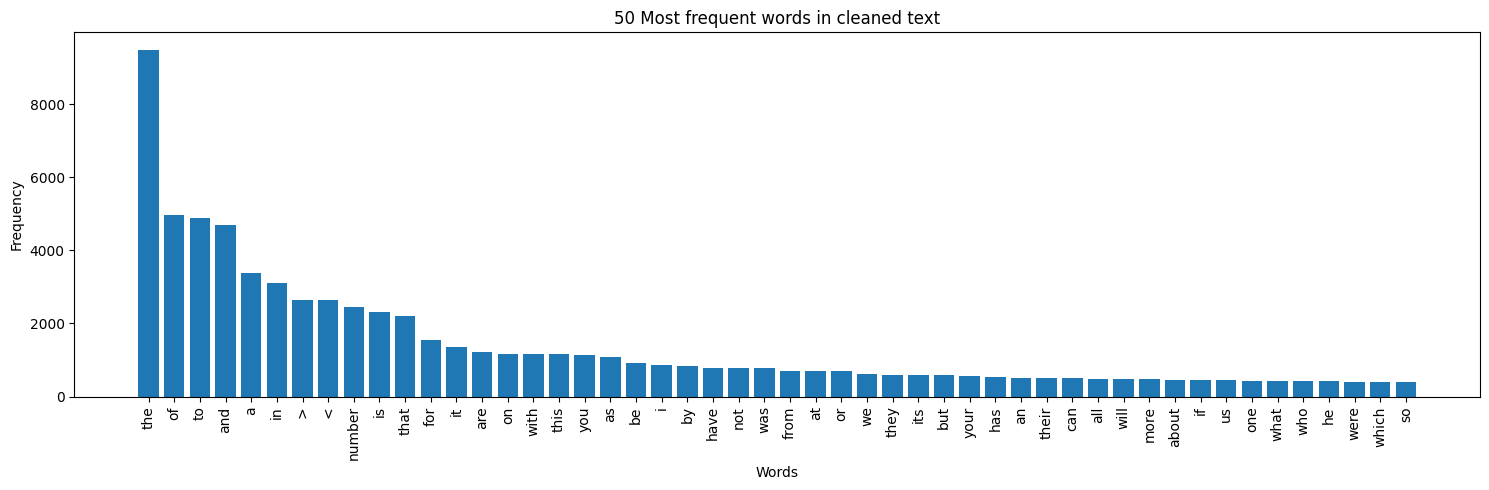

type
fake        186
reliable     21
Name: count, dtype: int64
type
fake        0.898551
reliable    0.101449
Name: proportion, dtype: float64


In [1]:
# 1: Import Dataset

import nltk
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from nltk.tokenize import word_tokenize
from cleantext import clean

nltk.download('punkt_tab')

# 1: Read the CSV file and save the original
df = pd.read_csv("news_sample.csv")

# Save the original raw text before cleaning
df['raw_content'] = df['content']

def clean_text_lib(text):
   return clean(text,
               lower=True,
               no_line_breaks=True,
               no_urls=True,
               no_emails=True,
               no_numbers=True,
               no_punct=True)
    
# 2: Clean the data 
df['clean_content'] = df['content'].apply(lambda x: clean_text_lib(x) if isinstance(x, str) else "")

# 3: get all raw data from 'content'
raw_text = " ".join(df['content'].dropna().tolist())
raw_tokens = word_tokenize(raw_text)
unique_raw_words = set(raw_tokens)
print("unique words in raw text:", len(unique_raw_words))

# Get all cleaned text from the new "clean_content" 
clean_text_all = " ".join(df['clean_content'].dropna().tolist())
clean_tokens = word_tokenize(clean_text_all)
unique_clean_words = set(clean_tokens)
print("unique words in cleaned text:", len(unique_clean_words))

# number of each word in cleaned text
word_freq = Counter(clean_tokens)
most_common_50 = word_freq.most_common(50)

# Extract words and frequencies
words, frequencies = zip(*most_common_50)

# Plot the 50 most frequent words
plt.figure(figsize=(15, 5))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("50 Most frequent words in cleaned text")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()





# 2: Dataset Analysis

# A: Determine which article types should be omitted, if any.

# leave out satire (just humor)
df = df[df['type'] != 'satire']
# Has no data
df = df[df['type'] != 'state']
# misleading science
df = df[df['type'] != 'junksci']
# not reliable, just hate
df = df[df['type'] != 'hate']
# exaggerated
df = df[df['type'] != 'clickbait']
# specefic viewpoint
df = df[df['type'] != 'political']



# B: Group the remaining types into 'fake' and 'reliable'. Argue for your choice.

# fake
df['type'] = df['type'].replace(['conspiracy', 'fake'], 'fake')


#reliable
df['type'] = df['type'].replace(['unreliable', 'bias', 'unreliable', 'unknown'], 'reliable')
print(df['type'].value_counts())

# C: Examine the percentage distribution of 'reliable' vs. 'fake' articles. Is the dataset balanced? Discuss the importance of a balanced distribution.

# reliable vs fake - percentage
print(df['type'].value_counts(normalize=True))


In [1]:
# 1) Library Installation:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementNotInteractableException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import csv
import time

# 2) Retrieve HTML Content:
browser = webdriver.Firefox()
wait = WebDriverWait(browser, 10)
# Track visited links to avoid duplicates
extracted_links = set()

# Reject cookies only once (as an iframe)
def reject_cookies(driver):
    try:
        iframe = wait.until(
            EC.frame_to_be_available_and_switch_to_it(
                (By.CSS_SELECTOR, "iframe[id^='sp_message_iframe']")
            )
        )
        reject_button = wait.until(
            EC.element_to_be_clickable(
                (By.XPATH, "//button[contains(text(), 'I do not agree')]")
            )
        )
        reject_button.click()
        print("Cookies rejected")
    except TimeoutException:
        print("No cookie popup detected")
    except Exception as e:
        print(f"Error handling cookies: {e}")
    finally:
        driver.switch_to.default_content()
        time.sleep(2)

# 3) Extract Articles:
def extract_articles(driver):
    articles = []
    # Wait for at least one article
    try:
        wait.until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "article a[data-testid='internal-link']"))
        )
    except TimeoutException:
        print("No articles found on this page")
        return articles
    links = driver.find_elements(By.CSS_SELECTOR, "article a[data-testid='internal-link']")
    for link_ele in links:
        try:
            title = link_ele.text.strip() or "No title"
            summary = "No summary"
            link = link_ele.get_attribute("href")
            if link not in extracted_links:
                extracted_links.add(link)
                articles.append({
                    "title": title,
                    "summary": summary,
                    "link": link
                })
        except Exception as e:
            print(f"Error extracting an article: {e}")
            continue
    print(f"Extracted {len(articles)} new articles from this page")
    return articles

# 4) Scrape Multiple Pages:
def scrape_region(driver, url):
    all_articles = []
    driver.get(url)
    time.sleep(3) 
    page_num = 1
    # Limit to avoid infinite loops
    max_pages = 50 
    
    while page_num <= max_pages:
        page_articles = extract_articles(driver)
        all_articles.extend(page_articles)
        try:
            next_button = driver.find_element(By.CSS_SELECTOR, "button[data-testid='pagination-next-button']")
            if next_button.get_attribute("disabled"):
                print(f"No more pages {page_num}")
                break
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", next_button)
            time.sleep(1)
            try:
                next_button.click()
            except ElementClickInterceptedException:
                ActionChains(driver).move_to_element(next_button).click().perform()

            page_num += 1
            print(f"Clicked 'Next Page' - page {page_num}")
            time.sleep(3)
        
        except NoSuchElementException:
            print(f"No 'Next Page' button on page {page_num}")
            break
        except ElementNotInteractableException:
            print(f"'Next Page' button not interactable on page {page_num}")
            break
    return all_articles

# 5) Expand the Scope:
try:
    browser.get("https://www.bbc.com/news/world/europe")
    time.sleep(3)
    reject_cookies(browser)

    regions = [
        "world/europe", "world/us_and_canada", "uk", "world/australia", "world/asia",
        "world/africa", "world/latin_america", "world/middle_east"
    ]
    all_articles = []
    
    for region in regions:
        print(f"\n Scraping region: {region}")
        url = f"https://www.bbc.com/news/{region.lstrip('/')}"
        region_articles = scrape_region(browser, url)
        all_articles.extend(region_articles)
        time.sleep(2)
finally:
    browser.quit()

# 6) Save Your Results:
with open("bbc_articles.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["title", "summary", "link"])
    writer.writeheader()
    writer.writerows(all_articles)

print(f"\nDone! TOTAL unique Extracted articles: {len(all_articles)}")

Cookies rejected

 Scraping region: world/europe
Extracted 27 new articles from this page
Clicked 'Next Page' - page 2
Extracted 6 new articles from this page
Clicked 'Next Page' - page 3
Extracted 9 new articles from this page
Clicked 'Next Page' - page 4
Extracted 8 new articles from this page
Clicked 'Next Page' - page 5
Extracted 7 new articles from this page
Clicked 'Next Page' - page 6
Extracted 9 new articles from this page
Clicked 'Next Page' - page 7
Extracted 9 new articles from this page
Clicked 'Next Page' - page 8
Extracted 9 new articles from this page
Clicked 'Next Page' - page 9
Extracted 9 new articles from this page
Clicked 'Next Page' - page 10
Extracted 9 new articles from this page
Clicked 'Next Page' - page 11
Extracted 9 new articles from this page
Clicked 'Next Page' - page 12
Extracted 1 new articles from this page
No more pages 12

 Scraping region: world/us_and_canada
Extracted 21 new articles from this page
Clicked 'Next Page' - page 2
Extracted 6 new articl

## Part 3: Scraping Article Text

 1) Article Inspection: 


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import csv
import time

# Initialize Selenium WebDriver
browser = webdriver.Firefox()
wait = WebDriverWait(browser, 10)

# 2) Text Scraping Function:
def scrape_article(url):
    try:
        browser.get(url)
        time.sleep(3)
        soup = BeautifulSoup(browser.page_source, "html.parser")
        title = soup.find("h1").text.strip() if soup.find("h1") else "No title"
        author = "No author"
        author_tag = soup.find("span", class_=lambda x: x and "sc-b42e7a8f" in x)  
        if author_tag:
            author = author_tag.text.strip()
        date = "No date"
        date_tag = soup.find("time")
        if date_tag:
            date = date_tag.text.strip()
        content = ""
        paragraphs = soup.find_all("p")
        for p in paragraphs:
            content += p.text.strip() + "\n"
        return {
            "title": title,
            "author": author,
            "date": date,
            "content": content.strip()
        }
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load article from bbc_articles.csv
article_links = []
with open("bbc_articles.csv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        article_links.append(row["link"])

# 3) Scrape All Articles:
scraped_articles = []
for link in article_links:
    print(f"Scraping: {link}")
    article_data = scrape_article(link)
    if article_data:
        scraped_articles.append(article_data)
    # Avoid getting blocked
    time.sleep(2)  

# 4) Data Storage:
with open("bbc_scraped_articles.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["title", "author", "date", "content"])
    writer.writeheader()
    writer.writerows(scraped_articles)
print(f"\nDone! Extracted {len(scraped_articles)} articles")
# Close the browser
browser.quit()

Scraping: https://www.bbc.com/news/articles/cy4lj15lyv3o
Scraping: https://www.bbc.com/news/articles/cjw27gnjjjyo
Scraping: https://www.bbc.com/news/articles/crmjewpkje9o
Scraping: https://www.bbc.com/news/articles/c0rz0jvvpwwo
Scraping: https://www.bbc.com/news/articles/c1kjwmzvg23o
Scraping: https://www.bbc.com/news/articles/crknjxj3n4zo
Scraping: https://www.bbc.com/news/articles/cqjd78jpqj9o
Scraping: https://www.bbc.com/news/articles/cy83r93l208o
Scraping: https://www.bbc.com/news/articles/c17qnxrq1y7o
Scraping: https://www.bbc.com/news/articles/cvg13rmnvzvo
Scraping: https://www.bbc.com/news/articles/czedpnen168o
Scraping: https://www.bbc.com/news/articles/cly2dz0qgxlo
Scraping: https://www.bbc.com/news/articles/c627685p21eo
Scraping: https://www.bbc.com/news/articles/cz7v1ejv01go
Scraping: https://www.bbc.com/news/articles/cdjyxljyjxno
Scraping: https://www.bbc.com/news/articles/czxnekw9lyjo
Scraping: https://www.bbc.com/news/articles/ce98xnldr0vo
Scraping: https://www.bbc.com/n

5. Discussion: Expanding the dataset has both positive and negatives. 

Pros:
* Multiple regions, reduces bias and improves analysis
* Helps compare reginal news trens and priorities.
* Improves generalization
* Bias detection, more sources

Cons:
* inconsistent data, different formats, metadata availability.
* more data = longer scraping times and higher resource demands.

Conclusion: If done correctly and structured, then expaniding the dataset is valuable for research.